In [1]:
#caution
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Github/flare-cme/2024

Mounted at /content/drive
/content/drive/MyDrive/Github/flare-cme/2024


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
positive = pd.read_csv("positive_2024.csv")
positive = positive.drop(["Unnamed: 0","HARPNUM","NOAA","Class","Peak Time"],axis =1)
negative = pd.read_csv("negative_2024.csv")
negative = negative.drop(["Unnamed: 0","HARPNUM","NOAA","Class","Peak Time"],axis =1)

## Normalisation

In [3]:
def normalize_the_data(flare_data):
    flare_data = np.array(flare_data)
    n_elements = flare_data.shape[0]
    for j in range(flare_data.shape[1]):
        standard_deviation_of_this_feature = np.std(flare_data[:, j])
        median_of_this_feature = np.median(flare_data[:, j])
        for i in range(n_elements):
            flare_data[i, j] = (
                flare_data[i, j] - median_of_this_feature) / (standard_deviation_of_this_feature)
    return flare_data

cme_n1 = normalize_the_data(positive)
cme_n2 = normalize_the_data(negative)

In [8]:
data = np.vstack([cme_n1,cme_n2])

In [6]:
df

array([[-0.46536668,  0.47374769,  1.28166813, ..., -0.37975426,
         0.24462242,  0.42433547],
       [-0.46818452, -0.42792629, -0.2371418 , ..., -0.37019507,
        -0.67179889, -0.51177594],
       [ 0.55395775, -0.59886283,  0.37110222, ...,  0.20433691,
         0.35415485,  0.24547447],
       ...,
       [ 0.28119301,  0.91916195, -1.337494  , ...,  0.92898718,
         0.55870618,  1.29512428],
       [ 0.29644332,  0.94558428, -1.29566043, ...,  0.91940123,
         0.48714775,  1.26153836],
       [ 0.2949036 ,  0.91737565, -1.286172  , ...,  0.91537452,
         0.55687135,  1.24243351]], shape=(1141, 18))

In [9]:
from sklearn import svm
number_of_examples = data.shape[0]
C = 4.0
gamma = 0.075
class_weight = "balanced"
clf = svm.SVC(C=C, gamma=gamma, kernel='rbf', class_weight=class_weight,cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)

In [11]:
xdata = np.concatenate(data, axis=0)
ydata = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])), axis=0)

In [12]:
def confusion_table(pred, labels):
    """
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score

    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)

    Returns: true negative, false positive, true positive, false negative
    """
    Nobs = len(pred)
    TN = 0.
    TP = 0.
    FP = 0.
    FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print("Error! Observation could not be classified.")
    return TN, FP, TP, FN

In [14]:
from sklearn.model_selection import StratifiedKFold

# lists to hold the TSS and standard deviation of the TSS
array_of_avg_TSS = np.ndarray([50])
array_of_std_TSS = np.ndarray([50])

# xdata are the examples
# ydata are the labels
xdata = data
ydata = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])), axis=0)

# compute the TSS for a variety of k ranging from 2 to 52
# this is to see how the TSS varies as a function of k, and to test if k=10 really makes sense
for k in range(2, 52):
    skf = StratifiedKFold(n_splits=k, shuffle=True,random_state=42)
    these_TSS_for_this_k = []
    for train_index, test_index in skf.split(xdata, ydata):
        # xtrain are the examples in the training set
        xtrain = xdata[train_index]
        # ytrain are the labels in the training set
        ytrain = ydata[train_index]
        # xtest are the examples in the testing set
        xtest = xdata[test_index]
        ytest = ydata[test_index]    # ytest are the labels in the testing set
        clf.fit(xtrain, ytrain)
        TN, FP, TP, FN = confusion_table(clf.predict(xtest), ytest)
        if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
            these_TSS_for_this_k.append(np.nan)
            continue
        else:
            these_TSS_for_this_k.append(TP/(TP+FN) - FP/(FP+TN))
    TSS_k = np.array(these_TSS_for_this_k)
    array_of_avg_TSS[k-2] = np.mean(TSS_k)
    array_of_std_TSS[k-2] = np.std(TSS_k)

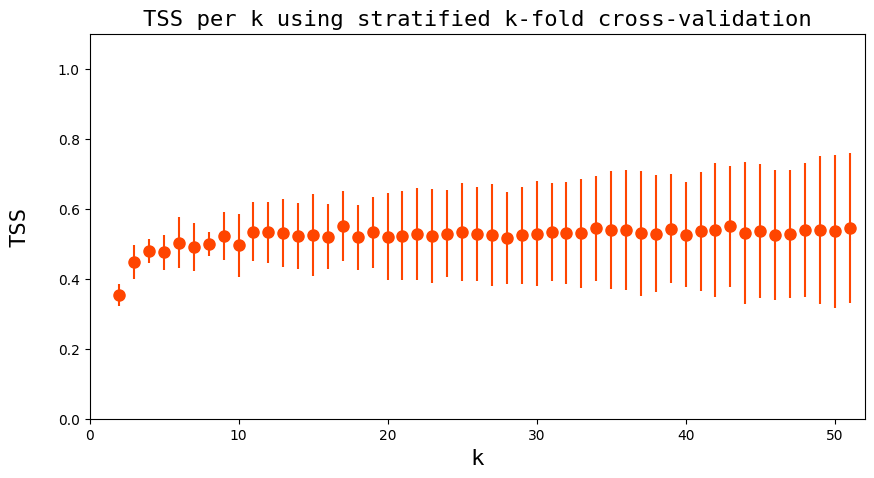

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))      # define the size of the figure
orangered = (1.0, 0.27, 0, 1.0)              # create an orange-red color
cornblue = (0.39, 0.58, 0.93, 1.0)           # create a cornflower-blue color

# define some style elements
marker_style_red = dict(linestyle='', markersize=8,
                        fillstyle='full', color=orangered, markeredgecolor=orangered)
marker_style_blue = dict(linestyle='', markersize=8,
                         fillstyle='full', color=cornblue, markeredgecolor=cornblue)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})

# ascribe the data to the axes
k = np.arange(50)+2
for i in range(50):
    if (array_of_avg_TSS[i] > array_of_std_TSS[i]):
        ax.errorbar(k[i], array_of_avg_TSS[i],yerr=array_of_std_TSS[i], linestyle='', color=orangered)
        ax.plot(k[i], array_of_avg_TSS[i], 'o', **marker_style_red)
    if (array_of_avg_TSS[i] <= array_of_std_TSS[i]):
        ax.errorbar(k[i], array_of_avg_TSS[i],yerr=array_of_std_TSS[i], linestyle='', color=cornblue)
        ax.plot(k[i], array_of_avg_TSS[i], 'o', **marker_style_blue)

# set plot limits
plt.xlim(xmax=52, xmin=0)
plt.ylim(ymax=1.1, ymin=0)

# label the axes and the plot
ax.set_xlabel('k', **text_style)
ax.set_ylabel('TSS', labelpad=20, **text_style)
plt.title(r'TSS per k using stratified k-fold cross-validation', **text_style)
fig = plt.gcf()
fig.set_size_inches(10, 5)

In [16]:
print("The TSS equals", array_of_avg_TSS[9],"plus or minus", array_of_std_TSS[9], ".")

The TSS equals 0.5347269689374953 plus or minus 0.08442631087880997 .


In [17]:
data.shape

(1141, 18)

In [18]:
positive.shape

(305, 18)

In [19]:
negative.shape

(836, 18)